# Nuts dealing

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os 

<Axes: >

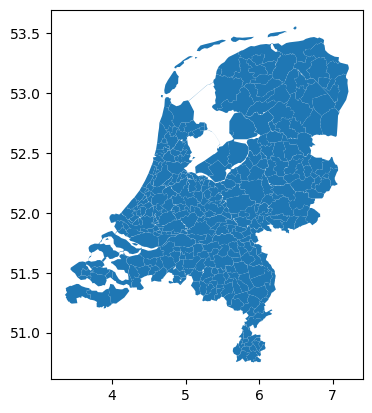

In [2]:
# mappings
import json

with open("data/raw/geospatial/harmonization/nl_ggd_mapping.json", "r") as f:
    ggd_nuts2_mapping = json.load(f)

with open("data/raw/geospatial/harmonization/nl_gemeenten_mapping.json", "r") as f:
    gemeenten_ggd_mapping = json.load(f)

nuts_data = pd.read_excel('data/raw/geospatial/harmonization/NUTS2021-NUTS2024.xlsx', sheet_name="NUTS2024")
nuts_data_nl = nuts_data[nuts_data['Country code'] == 'NL'].reset_index(drop=True)
mapping = {'Friesland (NL)' : "Friesland",
           'Limburg (NL)'   : 'Limburg',
           'Extra-Regio NUTS 1': pd.NA,
           'Extra-Regio NUTS 2': pd.NA,
           'Extra-Regio NUTS 3': pd.NA,                      
           }
nuts_data_nl['NUTS label'] = nuts_data_nl['NUTS label'].replace(mapping)
nuts_data_nl.dropna(inplace=True)
nuts_data_nl = nuts_data_nl.rename(columns = {'NUTS Code': 'nuts_code','NUTS label': 'nuts_name','NUTS level': 'nuts_level'})[['nuts_code', 'nuts_name','nuts_level']]

nuts1 = nuts_data_nl[nuts_data_nl['nuts_level'] == 1].reset_index(drop = True).rename(columns = {'nuts_code':'nuts1_code','nuts_name': 'nuts1_name'}).drop(columns = 'nuts_level')
nuts2 = nuts_data_nl[nuts_data_nl['nuts_level'] == 2].reset_index(drop = True).rename(columns = {'nuts_code':'nuts2_code','nuts_name': 'nuts2_name'}).drop(columns = 'nuts_level')
NUTS_HARM = nuts2.copy()
NUTS_HARM['nuts1_code'] = NUTS_HARM['nuts2_code'].str[:-1]

NUTS_HARM = pd.merge(NUTS_HARM,nuts1, on = 'nuts1_code')

NUTS_HARM = NUTS_HARM[['nuts2_code','nuts2_name','nuts1_code','nuts1_name']]

# process nuts2
import fiona

dir_shapefile_nl = 'data/raw/geospatial/shapefiles/bestuurlijkegrenzen.gpkg'

fiona.listlayers(dir_shapefile_nl)


shape_nuts2 = gpd.read_file(dir_shapefile_nl, layer = 'provincies')
shape_nuts2['provincienaam'] = shape_nuts2['provincienaam'].replace({'Fryslân':'Friesland'})

shape_nuts4 = gpd.read_file(dir_shapefile_nl, layer = 'gemeenten')
shape_ggd   =  gpd.read_file('data/raw/geospatial/shapefiles/ggd.geojson')
CRS         = shape_ggd.crs

shape_nuts2.to_crs(CRS, inplace=True)
shape_nuts4.to_crs(CRS, inplace=True)

ggd_harm = shape_ggd[['statcode', 'statnaam']].rename(columns = {'statcode':'ggd_code','statnaam':'ggd_name'})

ggd_harm['nuts2_code'] = ggd_harm['ggd_code'].replace(ggd_nuts2_mapping)

# with nuts1,nuts2,nuts3,ggd -> nexst is nuts4
NUTS_HARM = pd.merge(NUTS_HARM, ggd_harm, on = 'nuts2_code')

harmnuts4 = shape_nuts4[['code','gemeentenaam']]
harmnuts4['ggd_code'] = harmnuts4['code'].replace(gemeenten_ggd_mapping)
harmnuts4.rename(columns = {'code': 'nuts4_code','gemeentenaam': 'nuts4_name'}, inplace=True)

NUTS_HARM = pd.merge(NUTS_HARM, harmnuts4, on = 'ggd_code')

mapping_ggd_nuts1 = NUTS_HARM[['ggd_code','nuts1_code','nuts1_name']].drop_duplicates()
mapping_ggd_nuts2 = NUTS_HARM[['ggd_code','nuts2_code','nuts2_name']].drop_duplicates()

minimal_ggd_shapefile = shape_ggd[['statcode','geometry']].rename(columns = {'statcode':'ggd_code'})

# national
ggd_based_shapefile_nuts0 = gpd.GeoDataFrame(
    {"geometry": [shape_ggd.union_all(method = 'coverage')]},
    crs=CRS  # or whatever CRS your polygon uses
)


ggd_based_shapefile_nuts1 = pd.merge(minimal_ggd_shapefile, mapping_ggd_nuts1, on = 'ggd_code')
ggd_based_shapefile_nuts1 = ggd_based_shapefile_nuts1.dissolve(by="nuts1_code", aggfunc="first").drop(columns = ['ggd_code']).reset_index(drop = False)            # type: ignore[arg-type]

ggd_based_shapefile_nuts2 = pd.merge(minimal_ggd_shapefile, mapping_ggd_nuts2, on = 'ggd_code')
ggd_based_shapefile_nuts2 = ggd_based_shapefile_nuts2.dissolve(by="nuts2_code", aggfunc="first").drop(columns = ['ggd_code']).reset_index(drop = False)                # type: ignore[arg-type]

# to process:

current_shapefile = pd.merge(shape_nuts4[['code','geometry']].rename(columns = {'code':'nuts4_code'}), harmnuts4, on = 'nuts4_code')

# Create a mapping of nuts4_code to ggd geometry
ggd_geometries = shape_ggd.set_index('statcode')['geometry'].to_dict()

# Function to clip each nuts4 polygon to its corresponding ggd boundary
def clip_to_ggd(row):
    nuts4_geom = row['geometry']
    ggd_code = row['ggd_code']
    
    if ggd_code in ggd_geometries:
        ggd_geom = ggd_geometries[ggd_code]
        # Intersect the nuts4 polygon with its ggd boundary
        clipped_geom = nuts4_geom.intersection(ggd_geom)
        return clipped_geom
    else:
        # If no matching ggd found, return original geometry
        return nuts4_geom

# Apply the clipping
current_shapefile['geometry'] = current_shapefile.apply(clip_to_ggd, axis=1)

# Make sure it's still a proper GeoDataFrame
current_shapefile = gpd.GeoDataFrame(current_shapefile, geometry='geometry', crs=CRS)

# Optional: remove any empty or invalid geometries that might result
current_shapefile = current_shapefile[~current_shapefile.geometry.is_empty]
current_shapefile = current_shapefile[current_shapefile.geometry.is_valid]

current_shapefile.plot()

# Vaccination data

In [ ]:
# ggd regios in vaxdata:
rename_ggd_regios_vaxdata = {
'GGD Groningen'                     :   'GGD Groningen', 
'GGD Drenthe'                       :   'GGD Drenthe', 
'GGD IJsselland'                    :   'GGD IJsselland',
'GGD Regio Twente'                  :   'GGD Twente',     
'GGD Noord- en Oost-Gelderland'     :   'GGD Noord- en Oost-Gelderland',
'Veiligh. en Gez. Gelderland-Midden':   'Veiligheids- en Gezondheidsregio Gelderland-Midden', 
'GGD Gelderland-Zuid'               :   'GGD Gelderland-Zuid',
'GGD Flevoland'                     :   'GGD Flevoland', 
'GGD Regio Utrecht'                 :   'GGD Regio Utrecht', 
'GGD Hollands-Noorden'              :   'GGD Hollands-Noorden',
'GGD Kennemerland'                  :   'GGD Kennemerland', 
'GGD Amsterdam'                     :   'GGD Amsterdam',
'GGD Gooi en Vechtstreek'           :   'GGD Gooi en Vechtstreek',
'GGD Hollands-Midden'               :   'GGD Hollands-Midden', 
'GGD Rotterdam-Rijnmond'            :   'GGD Rotterdam-Rijnmond',
'Dienst Gezondheid & Jeugd ZHZ'     :   'Dienst Gezondheid & Jeugd ZHZ',
'GGD Zeeland'                       :   'GGD Zeeland',
'GGD West-Brabant'                  :   'GGD West-Brabant',
'GGD Hart voor Brabant'             :   'GGD Hart voor Brabant',
'GGD Brabant-Zuidoost'              :   'GGD Brabant-Zuidoost',
'GGD Limburg-Noord'                 :   'GGD Limburg-Noord', 
'GGD Zuid-Limburg'                  :   'GGD Zuid-Limburg',
'GGD Haaglanden'                    :   'GGD Haaglanden',
'GGD Fryslân'                       :   'GGD Fryslân',
'GGD Zaanstreek/Waterland'          :   'GGD Zaanstreek/Waterland'
}

vaxdata             = pd.read_csv('data/processed/epidemiological/vaxdata.csv', sep = ";")
vaxdata['region']   = vaxdata['region'].replace(rename_ggd_regios_vaxdata)

nuts0_vaccinations  = vaxdata[vaxdata['region'] == 'Nederland']
ggd_vaccinations    = vaxdata[vaxdata['region'].isin(list(NUTS_HARM['ggd_name'].unique()))]

gemeenten_vaccinations= 

In [23]:
ggd_vaccinations

,vaccine,region,year,coverage
6860,DKTP basisimmuun (2 jaar),GGD Groningen,2006,95.9.0
6861,DKTP basisimmuun (2 jaar),GGD Groningen,2007,96.3.0
6862,DKTP basisimmuun (2 jaar),GGD Groningen,2008,96.3.0
6863,DKTP basisimmuun (2 jaar),GGD Groningen,2009,96.2.0
6864,DKTP basisimmuun (2 jaar),GGD Groningen,2010,96.4.0
...,...,...,...,...
117755,MenACWY volledig (15 jaar),GGD Zaanstreek/Waterland,2021,..0
117756,MenACWY volledig (15 jaar),GGD Zaanstreek/Waterland,2022,86.1.0
117757,MenACWY volledig (15 jaar),GGD Zaanstreek/Waterland,2023,82..0
117758,MenACWY volledig (15 jaar),GGD Zaanstreek/Waterland,2024,66.2.0


In [16]:
vaxdata['region'].nunique() - 25-1

342

In [17]:
len(shape_nuts4)

352